# Function to Calculate and Plot the Lorenz Curve and Coefficient from Porosity and Permeability Well Log Data

### Alan Scherman, Rice University, UT PGE 2020 SURI 
### Supervised by Dr. Michael Pyrcz 

***
### Load the required libraries 

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

***
### Declare function

In [8]:
def lorenz_coefficient(poros, perme, layer_thick = 0.25, depth = None, curve_plot = False):
   
    """Calculates Lorenz coefficient and curve of subsurface sample given porosity and permeability data.
    :param poros: porosities in %
    :type: 1D numpy.ndarray
    :param perme: permeabilities in mD
    :type: 1D numpy.ndarray
    :param layer_thick: uniform layer thickness; default 0.25 m;
                        if depth is not None, layer_thick is recalculated
    :type: int or float
    :param depth: default None for constant thickness; 
                  for variable layer thickness, enter 1D numpy.ndarray of depths in m
    :param curve_plot: default False; set to True to display the Lorenz Curve
    :type: boolean
    :return:lorenz_coeff: Lorenz Coefficient rounded to 3 decimal places
           :type: float
           :lorenz_plot: (optional) figure with plot of Lorenz Curve   
    """
        
    # Converting to row-oriented numpy.ndarrays (if necessary)
    
    if np.ndim(depth) == 2:
        depth = np.transpose(depth)[0,:]
    if np.ndim(poros) == 2:
        poros = np.transpose(poros)[0,:]
    if np.ndim(perme) == 2:
        perme = np.transpose(perme)[0,:]
   
    # Determining layer thickness array
    
    if depth is not None:
        layer_thick = depth - np.concatenate(([0],depth[:-1]))
    else:
        layer_thick = np.ones(len(poros))*layer_thick    
        
    # Exception handling
    
    if (all(isinstance(x, (int, float)) for x in layer_thick) or all(isinstance(x, (int, float)) for x in poros) or all(isinstance(x, (int, float)) for x in perme)) == False:
        raise TypeError('Not all array entries are integers or floats')
    
    elif len(layer_thick) != len(poros) or len(layer_thick) != len(perme):
        raise TypeError('There are not sufficient porosity/permeability measurements for all layers')
        
    elif (np.ndim(layer_thick) or np.ndim(poros) or np.ndim(perme)) != 1:
        raise TypeError('Arguments should be 1D numpy.ndarrays')
    
    # Sorting data in descending order of perme/poros
    
    ratio = perme/poros
    layer_thick = np.flip(layer_thick[np.argsort(ratio)], axis = 0)
    poros = np.flip(poros[np.argsort(ratio)], axis = 0)
    perme = np.flip(perme[np.argsort(ratio)], axis = 0)
    
    # Flow and storage capacities
    
    storage_cap = poros*layer_thick
    flow_cap = perme*layer_thick
    
    # Cumulative flow and storage capacities
    
    cumul_storage_cap = np.zeros(len(flow_cap)+1)
    cumul_flow_cap = np.zeros(len(flow_cap)+1)
    
    cumul_storage_cap[1] = storage_cap[0]
    cumul_flow_cap[1] = flow_cap[0]
        
    for i in range(2,len(flow_cap)+1):
        cumul_storage_cap[i] = cumul_storage_cap[i-1] + storage_cap[i-1]
        cumul_flow_cap[i] = cumul_flow_cap[i-1] + flow_cap[i-1]
                     
    # Fractional flow and storage capacities
    
    frac_storage_cap = cumul_storage_cap/cumul_storage_cap[-1]
    frac_flow_cap = cumul_flow_cap/cumul_flow_cap[-1]
       
    # Curve fitting
    
    weights = np.ones(len(frac_storage_cap)) # To ensure the fit converges to (0,0) and (1,1)
    weights[0] = 1000; weights[-1] = 1000 
    
    poly_fit = np.polyfit(frac_storage_cap, frac_flow_cap, deg=3, w=weights)
    
    poly_fit = np.poly1d(poly_fit)
    integral = np.polyint(poly_fit) 
    lorenz_coeff = (integral(1) - 0.5)/0.5
    
    if curve_plot == True:                                                    # To output Lorenz Curve plot                           
         
        # Plotting instructions 
        
        lorenz_plot = plt.figure(figsize = (16,12))

        plt.style.use('fivethirtyeight')

        plt.plot([0,1],[0,1], label='Homogeneous Curve', color = 'red', linewidth = '3')
        plt.plot(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)), linestyle = 'dashed', \
                 linewidth = '3', label = 'Polynomial Fit', color = 'black')
        plt.fill_between(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)), np.linspace(0,1,100), alpha = 0.75)
        plt.fill_between(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)), 1, alpha = 0.75, color = 'orange')
    
        plt.title('Lorenz Curve and Coefficient', size = 50)
        plt.xlabel('Fraction of Total Storage Capacity (m)', size = 36)
        plt.ylabel('Fraction of Total Flow Capacity (mD*m)', size = 36)
        plt.legend(loc = 4, facecolor = '#C0C0C0', fontsize = 25)
        plt.text(0.3, 0.7, 'lorenz_coeff = \n %.3f' %lorenz_coeff, size = 40, horizontalalignment = 'center', \
                 bbox=dict(facecolor='none', edgecolor='black'))
    
        plt.show()
           
    else:                                                                   # To output only Lorenz Coefficient
        return 'lorenz_coeff = %.3f' %lorenz_coeff

***
### Docstrings

In [9]:
print(lorenz_coefficient.__doc__)

Calculates Lorenz coefficient and curve of subsurface sample given porosity and permeability data.
    :param poros: porosities in %
    :type: 1D numpy.ndarray
    :param perme: permeabilities in mD
    :type: 1D numpy.ndarray
    :param layer_thick: uniform layer thickness; default 0.25 m;
                        if depth is not None, layer_thick is recalculated
    :type: int or float
    :param depth: default None for constant thickness; 
                  for variable layer thickness, enter 1D numpy.ndarray of depths in m
    :param curve_plot: default False; set to True to display the Lorenz Curve
    :type: boolean
    :return:lorenz_coeff: Lorenz Coefficient rounded to 3 decimal places
           :type: float
           :lorenz_plot: (optional) figure with plot of Lorenz Curve   
    


***
### Examples

#### E.g. 1: Lorenz coefficient with default parameters (Data set 1)

In [10]:
df = pd.read_excel('WellPorPermSample_1.xlsx')
poros1 = pd.DataFrame(df, columns = ['Por (%)']); poros1 = poros1.to_numpy()
perme1 = pd.DataFrame(df, columns = ['Perm (mD)']); perme1 = perme1.to_numpy()

lorenz_coefficient(poros1, perme1)

'lorenz_coeff = 0.171'

#### E.g. 2: Lorenz curve and coefficient with irregular thicknesses (Data set 2)

<ipython-input-8-d2a6cb3c1a42>:49: RuntimeWarning: divide by zero encountered in true_divide
  ratio = perme/poros


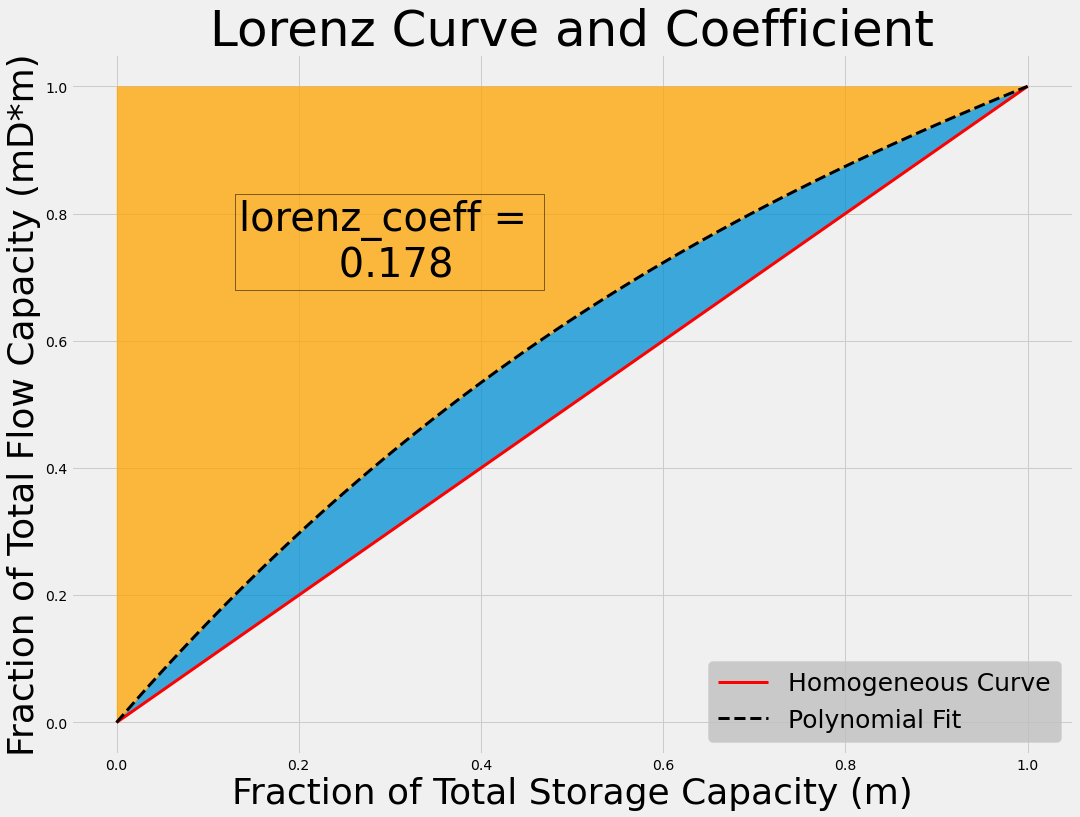

In [11]:
df = pd.read_excel('WellPorPermSample_2.xlsx')
depth2 = pd.DataFrame(df, columns = ['Depth (m)']); depth2 = depth2.to_numpy()
poros2 = pd.DataFrame(df, columns = ['Por (%)']); poros2 = poros2.to_numpy()
perme2 = pd.DataFrame(df, columns = ['Perm (mD)']); perme2 = perme2.to_numpy()

lorenz_coefficient(poros2, perme2, depth = depth2, curve_plot = True)

#### E.g. 3: Lorenz coefficient with customized uniform thickness (Data set 3)

In [12]:
df = pd.read_excel('WellPorPermSample_3.xlsx')
depth3 = pd.DataFrame(df, columns = ['Depth (m)']); depth3 = depth3.to_numpy()
poros3 = pd.DataFrame(df, columns = ['Por (%)']); poros3 = poros3.to_numpy()
perme3 = pd.DataFrame(df, columns = ['Perm (mD)']); perme3 = perme3.to_numpy()

lorenz_coefficient(poros3, perme3, layer_thick = 1.5)

'lorenz_coeff = 0.192'